In [1]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from itertools import product
import sys,time
import os
import pickle
from LaSDI import LaSDI

In [2]:
!nvidia-smi
torch.cuda.empty_cache()

Sun Sep 19 16:23:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.95.01    Driver Version: 440.95.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:04:00.0 Off |                    0 |
| N/A   40C    P0    54W / 300W |   9251MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000004:05:00.0 Off |                    0 |
| N/A   41C    P0    53W / 300W |   6664MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

# Discover Latent Space Dynamics

In [4]:
# ### Load Data if Model Already Exists ###
snapshot_full = pickle.load(open("./data/snapshot_git.p", 'rb'))
snapshot_full = snapshot_full[:,:-1].astype('float32')
snapshot_full_FOM = pickle.load(open("./data/FOM.p",'rb'))
FOM_time = snapshot_full_FOM['time']
snapshot_full_FOM = snapshot_full_FOM['FOM'][:,:-1].astype('float32')


In [5]:
# Set print option
np.set_printoptions(threshold=sys.maxsize)

# Choose device that is not being used
gpu_ids = "0"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device, '\n')

Using device: cuda 



Sparsity in 1000 by 12024 mask: 99.70%


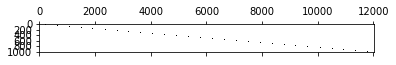

<All keys matched successfully>

In [6]:
model = torch.load('./model/AE_git.tar', map_location=device)    

maxk = 10
convergence_threshold = 1.0e-8

nx = 1001
dx = 6 / (nx - 1)
nt = 1000
tstop = 1
x=np.linspace(-3, 3, nx)

dt = tstop / nt 
c = dt/dx
t = np.linspace(0, tstop, nt)

def silu(input):
    return input * torch.sigmoid(input)
class SiLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return silu(input)
    
class Encoder(nn.Module):
    def __init__(self,m,M1,f):
        super(Encoder,self).__init__()
        self.full = nn.Sequential(
            nn.Linear(m,M1),
            SiLU(),
            nn.Linear(M1,f,bias=False)
        )
                
    def forward(self, y):     
        y = y.view(-1,m)
        T = self.full(y)
        T = T.squeeze()
        
        return T
    
class Decoder(nn.Module):
    def __init__(self,f,M2,m):
        super(Decoder,self).__init__()
        self.full = nn.Sequential(
            nn.Linear(f,M2,bias=False),
            SiLU(),
            nn.Linear(M2,m,bias=False)
        )
             
    def forward(self,T):
        T = T.view(-1,f)
        y = self.full(T)
        y = y.squeeze()
        
        return y
m = 1000
f = 4
b = 36
db = 12
M2 = b + (m-1)*db
M1 = 2*m
 

encoder = Encoder(m,M1,f).to(device)
decoder = Decoder(f,M2,m).to(device)

def create_mask_v2(m,b,db):
    '''
    mask=create_mask_v2(m,b,db)  
    '''
    
    M2 = b + db*(m-1)
    mask = np.zeros((m,M2),dtype='int')
    
    block = np.ones(b,dtype='int')
    ind = np.arange(b)
    for row in range(m):
        col = ind + row*db
        mask[row,col] = block
    
    print(
        "Sparsity in {} by {} mask: {:.2f}%".format(
            m, M2, (1.0-np.count_nonzero(mask)/mask.size)*100
        )
    )
    
    plt.figure()
    plt.spy(mask)
    plt.show()

    return mask

# Prune
mask = create_mask_v2(m,b,db)
prune.custom_from_mask(decoder.full[2], name='weight', mask=torch.tensor(mask).to(device))    

#     optimizer = torch.optim.LBFGS(list(encoder.parameters()) + list(decoder.parameters()), lr=1)
#     scheduler = None     
# optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,patience=10) 

loss_func = nn.MSELoss(reduction='mean')

encoder.load_state_dict(model['encoder_state_dict'])
decoder.load_state_dict(model['decoder_state_dict'])

In [7]:
amp_arr = np.array([.75,.85])
width_arr = np.array([.95,1.05])
P = list(product(amp_arr, width_arr))
P = np.array(P)

latent_space_SS = []
ndata = snapshot_full.shape[0]
nset = int(ndata/(nt+1))
for foo in range(nset):
    input_SS=torch.tensor(snapshot_full[foo*(nt+1):(foo+1)*(nt+1)].astype('float32')).to(device)
    latent_space = encoder(input_SS).cpu().detach().numpy()
    latent_space_SS.append(latent_space)

x0' = -1.360 1 + -0.362 x0 + -0.583 x1 + -0.451 x2 + 2.068 x3
x1' = 1.225 1 + -1.787 x0 + -1.797 x1 + -0.550 x2 + 4.922 x3
x2' = 6.212 1 + 1.444 x0 + 2.368 x1 + 1.960 x2 + -8.800 x3
x3' = 1.931 1 + -0.138 x0 + 0.207 x1 + 0.444 x2 + -0.948 x3


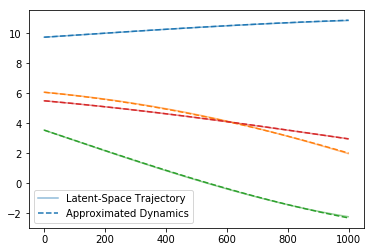

In [8]:
degree = 1
normal = 1
LaSDI_model = LaSDI(encoder, decoder, NN = True, device = 'cuda')
LaSDI_model.train_dynamics(latent_space_SS, P, dt)

## Test Dynamics on FOM

Final Position Error: 0.413%


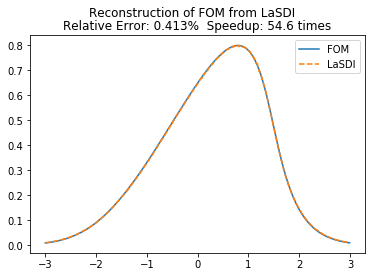

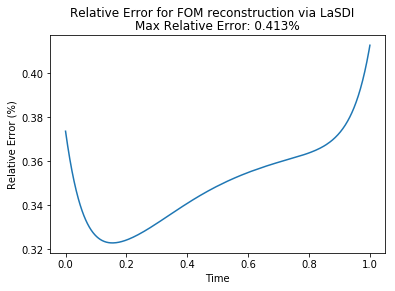

In [11]:
start = time.time()
FOM_recon = LaSDI_model.generate_FOM(snapshot_full_FOM[0], np.array([0.8,1.0]),t)
LaSDI_time = time.time()-start

print('Final Position Error: {:.3}%'.format(LA.norm(FOM_recon[-1]-snapshot_full_FOM[-2])/LA.norm(snapshot_full_FOM[-2])*100))
fig = plt.figure()
ax = plt.axes()
fig.suptitle('Reconstruction of FOM from LaSDI')
ax.set_title('Relative Error: {:.3}%  Speedup: {:.3} times'.format(LA.norm(FOM_recon[-1]-snapshot_full_FOM[-2])/LA.norm(snapshot_full_FOM[-2])*100, FOM_time/LaSDI_time))
ax.plot(x[:-1],snapshot_full_FOM[-1], label = 'FOM')
ax.plot(x[:-1], FOM_recon[-1],'--', label = 'LaSDI')
ax.legend()


FOM_re = np.empty(nt)
for i in range(nt):
    FOM_re[i] = LA.norm(FOM_recon[i]-snapshot_full_FOM[i])/LA.norm(snapshot_full_FOM[i])

fig = plt.figure()
fig.suptitle('Relative Error for FOM reconstruction via LaSDI')
ax = plt.axes()
ax.set_title('Max Relative Error: {:.3}%'.format(np.amax(FOM_re)*100))
ax.plot(t, FOM_re*100)
ax.set_xlabel('Time')
ax.set_ylabel('Relative Error (%)')
torch.cuda.empty_cache()